In [6]:
import pickle
from isce2.components import isceobj
import numpy as np
import matplotlib.pyplot as plt
import pathlib


In [ ]:
alos1 = "ALPSRP021272170"
alos2 = "ALPSRP027982170"

In [7]:
dir = pathlib.Path("../data/isce2_outputs/ALPSRP021272170_ALPSRP027982170/")

In [8]:
with open(dir / "PICKLE/interferogram", "rb") as fp:
    res = pickle.load(fp)

In [9]:
res

{'stripmapProc': {'ISCE_VERSION': 'Release: 2.6.3, svn-, 20230418. Current svn-'}, 'reference': {'sensor': {'imagefile': ['/permafrost-prediction/src/py/data/alos_palsar/ALPSRP021272170/l1.0_data/20060618/ALPSRP021272170/IMG-HH-ALPSRP021272170-H1.0__D'], 'leaderfile': ['/permafrost-prediction/src/py/data/alos_palsar/ALPSRP021272170/l1.0_data/20060618/ALPSRP021272170/LED-ALPSRP021272170-H1.0__D'], 'resample_flag': '', 'output': '/permafrost-prediction/src/py/data/isce2_outputs/ALPSRP021272170_ALPSRP027982170/ALPSRP021272170_raw/ALPSRP021272170.raw', 'family': 'alos', 'name': 'reference'}, 'width': 20688, 'iBias': 63.5, 'qBias': 63.5, 'range_sampling_rate': 32000000.0, 'prf': 2132.1961620469, 'pri': 0.0004690000000000018, 'pulse_length': 2.7e-05, 'chirp_slope': -1037037037037.0371, 'wavelength': 0.2360571, 'lookSide': -1, 'frame': {'schheight': None, 'schvelocity': None, 'number_range_bins': 9480, 'squint_angle': 0.0009297207816125715, 'polarization': 'HH', 'number_of_samples': 20688, 'n

In [10]:
from isce2.components import isceobj
import numpy as np

In [11]:
# from DownsampleUnwrapper
def load_img(xml_path):
    assert xml_path.suffixes == ['.slc', '.xml']
    img = isceobj.createImage()
    img.load(xml_path)
    _dtype_map = {'cfloat':np.complex64,'float':np.float32,'byte':np.uint8}
    dtype = _dtype_map[img.dataType.lower()]
    width = img.getWidth()
    length = img.getLength()
    im = np.fromfile(str(xml_path)[:-4], dtype)
    assert img.bands in [1, 2], f"Unsupported number of bands: {img.bands}"
    if img.bands == 1:
        im = im.reshape([length,width])
    else:#the other option is the unw which is 2 bands BIL
        im = im.reshape([length, img.bands, width])
    return im

In [8]:
!ls {dir}

ALPSRP021272170_raw
ALPSRP021272170_raw.xml
ALPSRP021272170_slc
ALPSRP021272170_slc.xml
ALPSRP027982170_raw
ALPSRP027982170_raw.xml
ALPSRP027982170_slc
ALPSRP027982170_slc.xml
PICKLE
SplitSpectrum
alos_ALPSRP021272170.xml
alos_ALPSRP027982170.xml
coregisteredSlc
dem.crop
dem.crop.vrt
dem.crop.xml
demLat_N70_N72_Lon_W158_W154.dem
demLat_N70_N72_Lon_W158_W154.dem.vrt
demLat_N70_N72_Lon_W158_W154.dem.wgs84
demLat_N70_N72_Lon_W158_W154.dem.wgs84.vrt
demLat_N70_N72_Lon_W158_W154.dem.wgs84.xml
demLat_N70_N72_Lon_W158_W154.dem.xml
denseOffsets
denseampcor.log
geometry
interferogram
ionosphere
isce.log
misreg
off.log
offsets
resampinfo.bin
roi.log
stripmapApp_ALPSRP021272170_ALPSRP027982170.xml
stripmapProc.xml


In [9]:
# Looking at SLC
im = load_img(dir / 'ALPSRP021272170_slc/ALPSRP021272170.slc.xml') # load_img(dir / "20060618_slc/20060618.slc.xml")

PARSING ../data/isce2_outputs/ALPSRP021272170_ALPSRP027982170/ALPSRP021272170_slc/ALPSRP021272170.slc.xml


In [10]:
mag = np.abs(im)

In [11]:
mag_clip = np.clip(mag, 0.0, 5.0)

CPU times: user 311 ms, sys: 954 ms, total: 1.27 s
Wall time: 1.27 s


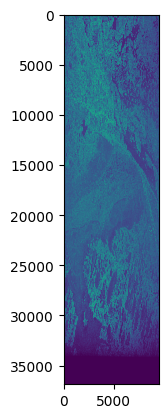

In [12]:
%%time
plt.imshow(mag_clip)

CPU times: user 341 ms, sys: 169 ms, total: 511 ms
Wall time: 528 ms


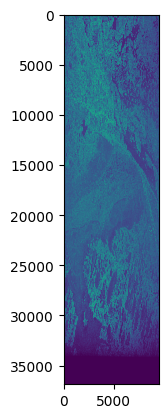

In [29]:
%%time
plt.imshow(mag_clip)

In [12]:
import gdal
import matplotlib.pyplot as plt

In [16]:
class LatLon:
    def __init__(self, results_dir):
        # reading the lat/lon
        ds = gdal.Open(str(dir / "geometry/lat.rdr"), gdal.GA_ReadOnly)
        lat = ds.GetRasterBand(1).ReadAsArray()
        ds = None
        
        # reading the lat/lon
        ds = gdal.Open(str(dir / "geometry/lon.rdr"), gdal.GA_ReadOnly)
        lon = ds.GetRasterBand(1).ReadAsArray()
        ds = None

        self.lat_arr = lat
        self.lon_arr = lon

    def find_closest_pixel(self, lat, lon):
        distances = np.sqrt((self.lat_arr - lat)**2 + (self.lon_arr - lon)**2)
        closest_pixel_idx = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        return closest_pixel_idx

lat_lon = LatLon(dir)


In [17]:
import pandas as pd
df_calm = pd.read_csv("/permafrost-prediction/src/py/data/calm/data/u1/data.csv", parse_dates=['date'])

In [41]:
import datetime

img1_dt = pd.to_datetime(datetime.datetime(2006, 6, 18))
img2_dt = pd.to_datetime(datetime.datetime(2006, 8, 3))

closest_img1_dt_idx = np.argmin(np.abs(df_calm['date'] - img1_dt))
closest_img1_dt = df_calm['date'][closest_img1_dt_idx]

closest_img2_dt_idx = np.argmin(np.abs(df_calm['date'] - img2_dt))
closest_img2_dt = df_calm['date'][closest_img2_dt_idx]

print(closest_img1_dt, img1_dt)
print(closest_img2_dt, img2_dt)

2006-06-24 00:00:00 2006-06-18 00:00:00
2006-08-06 00:00:00 2006-08-03 00:00:00


In [42]:
df_calm_img1 = df_calm[df_calm['date'] == closest_img1_dt]
df_calm_img2 = df_calm[df_calm['date'] == closest_img2_dt]

In [43]:
def try_float(x):
    try:
        return float(x)
    except:
        return np.nan

alt_img1 = df_calm_img1['alt_m'].apply(try_float)
alt_img2 = df_calm_img2['alt_m'].apply(try_float)

np.nanmean(alt_img1), np.nanmean(alt_img2)

(7.7478991596638656, 31.059322033898304)

In [44]:
df_calm_img1

,date,point_id,latitude,longitude,alt_m
2420,2006-06-24,1,71.31538,-156.602714,8.5
2421,2006-06-24,2,71.31534,-156.599920,9
2422,2006-06-24,3,71.31531,-156.597126,13
2423,2006-06-24,4,71.31527,-156.594332,0
2424,2006-06-24,5,71.31524,-156.591537,0
...,...,...,...,...,...
2536,2006-06-24,117,71.30621,-156.587064,13.5
2537,2006-06-24,118,71.30617,-156.584272,11
2538,2006-06-24,119,71.30614,-156.581479,13
2539,2006-06-24,120,71.30610,-156.578686,14


In [45]:
df_calm_img2

,date,point_id,latitude,longitude,alt_m
2541,2006-08-06,1,71.31538,-156.602714,25.5
2542,2006-08-06,2,71.31534,-156.599920,31
2543,2006-08-06,3,71.31531,-156.597126,55
2544,2006-08-06,4,71.31527,-156.594332,20
2545,2006-08-06,5,71.31524,-156.591537,27
...,...,...,...,...,...
2657,2006-08-06,117,71.30621,-156.587064,37.5
2658,2006-08-06,118,71.30617,-156.584272,29.5
2659,2006-08-06,119,71.30614,-156.581479,29.5
2660,2006-08-06,120,71.30610,-156.578686,33.5


In [46]:
np.nanmean(alt_img1[:3]), np.nanmean(alt_img2[:3])

(10.166666666666666, 37.166666666666664)

In [103]:
def find_closest_pixel(lat, lon):
    distances = np.sqrt((lat_lon[:,:,0] - lat)**2 + (lat_lon[:,:,1] - lon)**2)
    closest_pixel_idx = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    print(f"The closest pixel is at index {closest_pixel_idx} and has coordinates {lat_lon[closest_pixel_idx]}")
    return closest_pixel_idx

find_closest_pixel(71.31538, -156.602714)
find_closest_pixel(71.31534, -156.599920)
find_closest_pixel(71.31531, -156.597126)


The closest pixel is at index (2533, 1957) and has coordinates [  71.31550386 -156.60302646]
The closest pixel is at index (2533, 1953) and has coordinates [  71.31527187 -156.59986434]
The closest pixel is at index (2532, 1950) and has coordinates [  71.31531841 -156.59733193]


(2532, 1950)

In [55]:
# reading the multi-looked wrapped interferogram
ds = gdal.Open("../data/interferogram/filt_topophase.flat", gdal.GA_ReadOnly)
igram = ds.GetRasterBand(1).ReadAsArray()
ds = None

# reading the multi-looked unwrapped interferogram
ds = gdal.Open("../data/interferogram/filt_topophase.unw", gdal.GA_ReadOnly)
igram_unw = ds.GetRasterBand(2).ReadAsArray()
ds = None

# reading the connected component file
ds = gdal.Open("../data/interferogram/filt_topophase.unw.conncomp", gdal.GA_ReadOnly)
connected_components = ds.GetRasterBand(1).ReadAsArray()
ds = None

In [58]:
np.unique(connected_components)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=uint8)

2023-08-30 16:24:04,236 - matplotlib.colorbar - DEBUG - colorbar update normal <matplotlib.colors.Normalize object at 0x7f870f0d7b80> <matplotlib.colors.Normalize object at 0x7f870f0d7b80>
2023-08-30 16:24:04,237 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f870e6985b0>
2023-08-30 16:24:04,238 - matplotlib.colorbar - DEBUG - colorbar update normal <matplotlib.colors.Normalize object at 0x7f870f0d7b80> <matplotlib.colors.Normalize object at 0x7f870f0d7b80>
2023-08-30 16:24:04,239 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f870e6985b0>
2023-08-30 16:24:04,241 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.FixedLocator object at 0x7f870e782610>
2023-08-30 16:24:04,254 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f870e637490>
2023-08-30 16:24:04,265 - matplotlib.colorbar - DEBUG - colorbar update normal <matplotlib.colors.Normalize object at 0x7f870e587940>

[Text(0, 0, '0'), Text(20, 0, '20')]

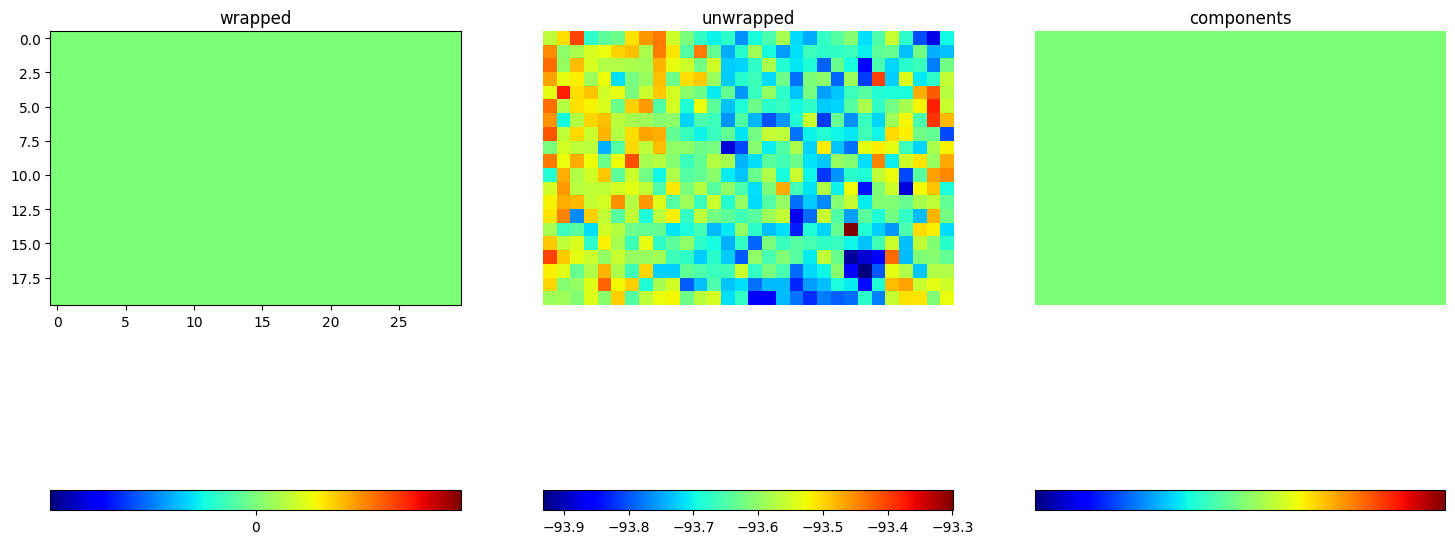

In [110]:
fig = plt.figure(figsize=(18, 16))

area = slice(2520, 2540), slice(1940, 1970)

ax = fig.add_subplot(1,3,1)
cax=ax.imshow(np.angle(igram[area]), cmap='jet')
ax.set_title("wrapped")
#ax.set_axis_off()
cbar = fig.colorbar(cax, ticks=[-3.14,0,3.14],orientation='horizontal')
cbar.ax.set_xticklabels(["$-\pi$",0,"$\pi$"])

ax = fig.add_subplot(1,3,2)
cax = ax.imshow(igram_unw[area], cmap = 'jet')
ax.set_title("unwrapped")
ax.set_axis_off()
cbar = fig.colorbar(cax, orientation='horizontal')

ax = fig.add_subplot(1,3,3)
cax = ax.imshow(connected_components[area], cmap = 'jet')
ax.set_title("components")
ax.set_axis_off()
cbar = fig.colorbar(cax, ticks=[0, 20] , orientation='horizontal')
cbar.ax.set_xticklabels([0,20])

In [125]:
alt_img2.values - alt_img1.values

array([17. , 22. , 42. , 20. , 27. , 17.5,  nan, 31.5, 23. , 16.5, 17. ,
       25. , 23. , 29. , 15. , 29. , 24.5, 23. , 20.5, 24. , 12.5, 16. ,
       26. , 25.5, 17. , 17.5, 34.5, 16. , 24.5, 23.5, 28. , 22.5, 17. ,
       21. , 25.5, 31.5, 51.5, 34.5, 23.5, 24. , 21.5, 30.5,  6.5, 12.5,
       19. , 19.5, 29. , 34.5, 29. , 20. , 25. , 26.5, 38. , 20.5, 21. ,
       16. , 23.5, 30. , 19.5, 30. , 17.5, 20.5, 30. , 27.5, 25.5, 18.5,
       14.5, 22. , 31. , 14.5, 45. , 23.5, 27.5, 29. , 30. , 18. , 26. ,
       13. , 21. , 25.5, 12.5, 50. , 24. , 35. , 17.5, 20. , 14. , 20. ,
       22. , 21.5, 31. , 15.5, 73. , 11. , 26. , 24.5, 13. , 12.5, 18.5,
       19.5, 23. , 28.5, 18. , 25.5, 17. , 16. , 19. , 23.5, 13.5,  nan,
       20.5, 23. , 26. , 13.5, 20.5, 10.5, 24. , 18.5, 16.5, 19.5,  nan])

In [120]:
df_calm_img2

,date,point_id,latitude,longitude,alt_m
2541,2006-08-06,1,71.31538,-156.602714,25.5
2542,2006-08-06,2,71.31534,-156.599920,31
2543,2006-08-06,3,71.31531,-156.597126,55
2544,2006-08-06,4,71.31527,-156.594332,20
2545,2006-08-06,5,71.31524,-156.591537,27
...,...,...,...,...,...
2657,2006-08-06,117,71.30621,-156.587064,37.5
2658,2006-08-06,118,71.30617,-156.584272,29.5
2659,2006-08-06,119,71.30614,-156.581479,29.5
2660,2006-08-06,120,71.30610,-156.578686,33.5


In [119]:
df_calm_img1

,date,point_id,latitude,longitude,alt_m
2420,2006-06-24,1,71.31538,-156.602714,8.5
2421,2006-06-24,2,71.31534,-156.599920,9
2422,2006-06-24,3,71.31531,-156.597126,13
2423,2006-06-24,4,71.31527,-156.594332,0
2424,2006-06-24,5,71.31524,-156.591537,0
...,...,...,...,...,...
2536,2006-06-24,117,71.30621,-156.587064,13.5
2537,2006-06-24,118,71.30617,-156.584272,11
2538,2006-06-24,119,71.30614,-156.581479,13
2539,2006-06-24,120,71.30610,-156.578686,14


In [1]:

# incidence angle
ia = 38.7*np.pi/180
wavelength = 0.2360571

# has unwrapping issue, deal w later
# negative cause we calculated (time_before) - (time_after), but
# we really want (time_after - time-before)?
los_def = -93/(2*np.pi)*wavelength

ground_def = los_def / np.cos(ia)

# # Plot the unwrapped phase or flattened interferogram
# plt.imshow(ground_def_cm, cmap='jet')
# plt.colorbar(label='Ground Deformation (cm)')
# plt.show()
ground_def

NameError: name 'np' is not defined

In [34]:
# Looking at interferogram?
intfg_flat = load_img("../data/interferogram/filt_topophase.flat.xml")
intfg_unw = load_img("../data/interferogram/filt_topophase.unw.xml")

In [37]:
intfg_flat.dtype, intfg_flat.shape, intfg_unw.dtype, intfg_unw.shape

(dtype('complex64'), (4608, 2370), dtype('float32'), (4608, 2, 2370))

2023-08-30 12:29:48,305 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-08-30 12:29:48,307 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-08-30 12:29:48,314 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-08-30 12:29:48,314 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-08-30 12:29:48,315 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='sca

(array([[   0.,    0.,    0., ...,   66.,   64.,   64.],
        [   0.,    0.,    0., ...,   65.,   64.,   65.],
        [   0.,    0.,    0., ...,   62.,   65.,   66.],
        ...,
        [1935.,  400., 1921., ...,   68.,   40.,    0.],
        [1934.,  408., 1916., ...,   69.,   40.,    0.],
        [1936.,  413., 1911., ...,   70.,   40.,    0.]]),
 array([-357.94726562, -266.08279419, -174.21833801,  -82.35386658,
           9.51059532,  101.37506104,  193.23953247,  285.10400391,
         376.96844482,  468.83291626,  560.6973877 ]),
 <a list of 2370 BarContainer objects>)

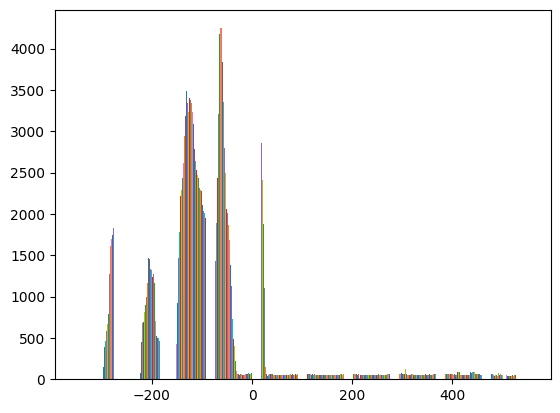

In [30]:
# from upsample_unw this appears to be phase (phase diff?) in radians
plt.hist(intfg[:,1,:])

In [38]:
angles = np.angle(intfg_flat)

2023-08-30 12:36:24,214 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f855d6a5190>


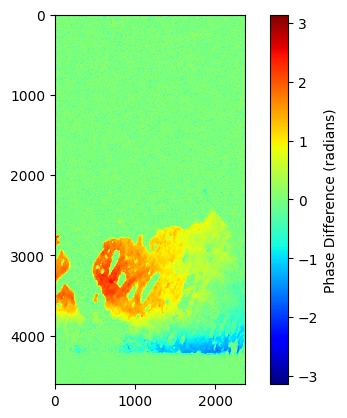

In [40]:
# Plot the unwrapped phase or flattened interferogram
plt.imshow(angles, cmap='jet')
plt.colorbar(label='Phase Difference (radians)')
plt.show()

2023-08-30 12:48:14,248 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f855d496b80>


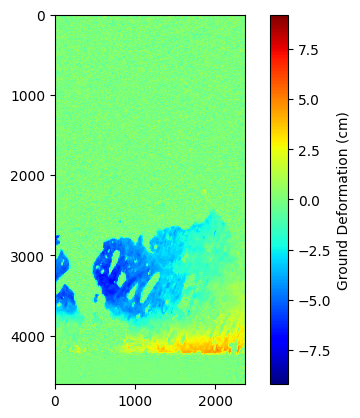

In [48]:
# incidence angle
ia = 38.7*np.pi/180
wavelength = 0.2360571

# has unwrapping issue, deal w later
# negative cause we calculated (time_before) - (time_after), but
# we really want (time_after - time-before)?
los_def = -angles/(2*np.pi)*wavelength

ground_def_cm = np.cos(ia) * los_def * 100

# Plot the unwrapped phase or flattened interferogram
plt.imshow(ground_def_cm, cmap='jet')
plt.colorbar(label='Ground Deformation (cm)')
plt.show()

2023-08-30 12:30:51,412 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f8561a25430>
2023-08-30 12:30:51,418 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2023-08-30 12:30:51,418 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-08-30 12:30:51,419 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2023-08-30 12:30:51,419 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/local/lib/python3.8

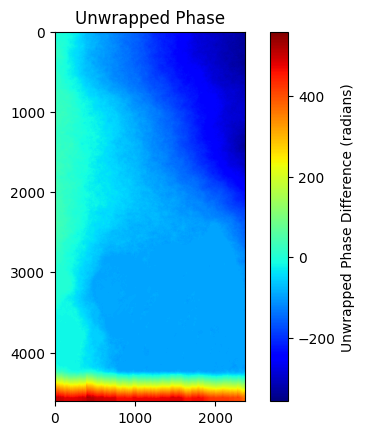

In [33]:
# Plot the unwrapped phase or flattened interferogram
plt.imshow(intfg[:,1,:], cmap='jet')
plt.colorbar(label='Unwrapped Phase Difference (radians)')
plt.show()